In [2]:
import pyemma as pm
import mdtraj as md
from molpx.generate import projection_paths
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
from typing import Dict, Union, List
from msmsense.featurizers import dihedrals, distances
from msmsense.bootstrap_cmatrices import get_sub_dict, get_trajs
from functools import partial

%matplotlib inline

import pickle
import time

In [3]:
def get_feature_dict(df, row_num):
    row_dict = df.filter(regex='__', axis=1).loc[row_num, :].to_dict()
    feature_dict = get_sub_dict(row_dict, 'feature')
    if feature_dict['value'] == 'distances':
        feature_dict.update(get_sub_dict(row_dict, 'distances'))
    if feature_dict['value'] == 'dihedrals':
        feature_dict.update(get_sub_dict(row_dict, 'dihedrals'))
    return feature_dict

def get_kws_dict(df, row_num, kws):
    row_dict = df.filter(regex='__', axis=1).loc[row_num, :].to_dict()   
    kws_dict = get_sub_dict(row_dict, kws)
    return kws_dict

def set_proper_dtypes(df):
    """
    forgot to save integers as integers. Only the distances feature columns have true floats. 
    """
    potential_integer_cols = df.columns.difference(list(df.filter(regex='distances.*', axis=1)))
    for col in potential_integer_cols:
        if str(df[col].dtype) != 'object':
            df[col] = df[col].astype(int)
    return df

def get_trajs_top(traj_dir: Path, protein_dir: str, rng: Union[np.random.Generator, None]=None):
    trajs = list(traj_dir.rglob(f"*{protein_dir.upper()}*/*.xtc"))
    trajs.sort()
    
    if rng is not None:
        ix = rng.choice(np.arange(len(trajs)), size=10, replace=True)
        trajs = [trajs[i] for i in ix]
    
    top = list(traj_dir.rglob(f"*{protein_dir.upper()}*/*.pdb"))[0]
    
    return {'trajs': trajs, 'top': top}
    

In [4]:
class MSM(object):
    
    def __init__(self, lag: int, num_evs: int, trajs: List[md.Trajectory], top: md.Trajectory,
                 feature_kws: Dict[str, Union[str, int, float]], tica_kws: Dict[str, Union[str, int, float]], cluster_kws: Dict[str, Union[str, int, float]]):
        """
        Defines the whole MSM pipeline.
        lag: markov lag time 
        num_evs: number of eigenvectors in VAMP score. This includes stationary distribution. note: all projections are done onto the processes 1 - num_evs, i.e., exclude the stationary distribution (process 0)
        traj_top_paths: dictionary with 'trajs' - list of Paths to trajectories, and 'top' Path to topology file. 
        
        """
        self.lag = lag
        self.num_evs = num_evs
        self.trajs = trajs
        self.top = top
        self.feature_kws = feature_kws
        self.tica_kws = tica_kws
        self.cluster_kws = cluster_kws
        self.featurizer = None
        self._set_featurizer()
        
        self.tica = None
        self.cluster = None
        self.msm = None
        self.paths = None
        
    def _set_featurizer(self):
        feature_kws = self.feature_kws.copy()
        feature = feature_kws.pop('value')
        
        if feature == 'distances':
            self.featurizer = partial(distances, **feature_kws)
        elif feature == 'dihedrals':
            self.featurizer = partial(dihedrals, **feature_kws)
        else:
            raise NotImplementedError('Unrecognized feature')
        

    def fit(self):
        ftrajs = self.featurizer(self.trajs)
        self.tica = pm.coordinates.tica(data=ftrajs, **self.tica_kws)
        ttrajs = self.tica.get_output()
        self.cluster = pm.coordinates.cluster_kmeans(data=ttrajs, **self.cluster_kws)
        dtrajs = self.cluster.dtrajs
        self.msm = pm.msm.estimate_markov_model(dtrajs=dtrajs, lag=self.lag)

    
    def _get_all_projections(self, num_procs: int, dtrajs: List[np.ndarray]) -> np.ndarray:
        """ Project dtrajs onto first num_proc eigenvectors excluding stationary distribution. i.e., if num_proc=1 then project onto the slowest eigenvector only. 
        All projections ignore the stationary distribution
        """
        evs = self.msm.eigenvectors_left(num_procs+1)
        active_set = self.msm.active_set
        non_active_set_val = 0 # if the state is not in the active set, set the projection to this value. 
        
        evs = evs[1:, :] # remove the stationary distribution
        proj_trajs = []
        for dtraj in dtrajs:
            all_procs = []
            for proc_num in range(num_procs):
                
                tmp = np.zeros(dtraj.shape[0], dtype=float)
                for i in range(dtraj.shape[0]):
                    x = dtraj[i]
                    if x in active_set:
                        tmp[i] = evs[proc_num, x]
                    else:
                        tmp[i] = non_active_set_val
                tmp = tmp.reshape(-1, 1)
                
                all_procs.append(tmp)
            all_procs = np.concatenate(all_procs, axis=1)
            proj_trajs.append(all_procs)
        
        return proj_trajs
        
        
    def projection_paths(self, n_projs: Union[None, int]=None, proj_dim: Union[None, int]=None, n_points: int=100, n_geom_samples: int=100):
        """
        n_projs: number of paths to create. Default = None = num_evs - 1 (i.e., exclude stationary distribution)
        proj_dim: dimensionality of the space in which distances will be computed. Default = None = num_evs - 1 (i.e., exclude stationary distribution)
        n_points: number of points along the path (there may be less than this.)
        n_geom_samples: For each of the n_points along the projection path, n_geom_samples will be retrieved from the trajectory files. 
                        The higher this number, the smoother the minRMSD projection path. Also, the longer it takes for the path to be computed
        """
        
        if proj_dim is None:
            proj_dim = self.num_evs - 1
        if n_projs is None:
            n_projs = self.num_evs - 1
        
        projections = self._get_all_projections(num_procs=proj_dim, dtrajs=self.msm.discrete_trajectories_active)
        
        paths, _ = projection_paths(MD_trajectories=self.trajs, MD_top = self.top, projected_trajectories=projections, 
                                    n_projs=n_projs, proj_dim=proj_dim, n_geom_samples=n_geom_samples, n_points=n_points)
        self.paths = paths
        
        
    
    def get_projection_trajectory(self, proc_num: int, kind: str='min_rmsd') -> md.Trajectory:
        """
        Returns the projection trajectory for a specific dimension
        proc_num: the number process. Min value = 1
        """
        if proc_num == 0:
            raise ValueError("process_num must be >=1. Processes are indexed from 0 (stationary distribution). Process 1 is the slowest projected process.")
            
        return self.paths[proc_num-1][kind]['geom']
    
    
    def transform(self, new_trajectory: md.Trajectory) -> np.ndarray:
        """
        projects new trajectory onto the self.num_proc eigenvectors of the MSM
        """
        ftrajs = self.featurizer([new_trajectory])
        ttrajs = self.tica.transform(ftrajs)
        dtrajs = self.cluster.transform(ttrajs)
        projections = self._get_all_projections(num_procs=self.num_evs - 1, dtrajs=dtrajs)
        return projections
        
        
    

In [5]:
traj_dir = Path('/Volumes/REA/MD/12FF/strided/')
protein_dir = '1FME'
out_dir = Path('/Volumes/REA/Data/fast_folders/model_comparisons/').joinpath(protein_dir)
out_dir.mkdir(exist_ok=True, parents=True)
comparator_ix = 0 # Always best because of sorting. 
num_bs_iter = 2
n_points = 50 # points along path
n_geom_samples = 50 # samples to create min rmsd

In [6]:

mod_defs = set_proper_dtypes(pd.read_hdf('../results/best_hps_per_feature.h5', key='best_hps_per_feature'))
mod_defs = mod_defs.loc[mod_defs.protein_dir==protein_dir.lower(), :]
mod_defs.sort_values(by=['protein', 'hp_rank'], inplace=True)
mod_defs.reset_index(inplace=True, drop=True)

In [7]:
mod_defs.to_hdf(out_dir.joinpath('model_definitions.h5'), key='model_definitions')

In [8]:
rng = np.random.default_rng(12098345)

for bs_num in range(num_bs_iter):
    print('BS iteration ', bs_num)
    tic = time.time()
    
    
    # Create output directory
    iter_out_dir = out_dir.joinpath(f"iter_{bs_num}")
    iter_out_dir.mkdir(exist_ok=True)

    # Sample traj paths and save results
    traj_paths = get_trajs_top(traj_dir, protein_dir, rng)
    assert len(traj_paths['trajs']) > 0, 'no trajectories found'
    pickle.dump(file=iter_out_dir.joinpath('input_paths.pkl').open('wb'), obj=traj_paths)

    top = md.load(str(traj_paths['top']))
    trajs = [md.load(str(x), top=top) for x in traj_paths['trajs']]
    print('\tfinished loading trajectories')
    
    # Fit models and find paths
    models = {}
    for row_num in mod_defs.index:
        print('Model num ', row_num)
        hp_ix = mod_defs.hp_index[row_num]
        hp_rank = mod_defs.hp_rank[row_num]
        
        # model hyperparameters
        lag = mod_defs.lag[row_num]
        num_evs = mod_defs.k[row_num]
        feat_kws = get_feature_dict(mod_defs, row_num)
        tica_kws = get_kws_dict(mod_defs, row_num, 'tica')
        cluster_kws = get_kws_dict(mod_defs, row_num, 'cluster')

        # Fit model
        model = MSM(lag = lag, num_evs=num_evs, trajs=trajs, top=top,  feature_kws=feat_kws, tica_kws=tica_kws, cluster_kws=cluster_kws)
        model.fit()
        print('\tfinished fitting model')
        # Estimate all paths
        
        model.projection_paths(n_points=n_points, n_geom_samples=n_geom_samples)
        print('\tfinished projecting paths')
        pickle.dump(file=iter_out_dir.joinpath(f"mod_{row_num}_hp_{hp_ix}_rank_{hp_rank}_paths.pkl").open('wb'), obj=model.paths)
        print('\tfinished dumping paths')
        # Accumulate models for comparisons
        models[row_num] = model
    
    
    # Do model comparisons
    for proc_num in list(models[comparator_ix].paths.keys()):  # shouldn't matter which model is used here. 
        print('\tcomparing path ', proc_num)
        paths = {k: v.get_projection_trajectory(proc_num+1) for k, v in models.items()}
        projs = {f"mod_{k}_on_mod_{comparator_ix}": models[comparator_ix].transform(v)[0] for k, v in paths.items()}
        pickle.dump(file=iter_out_dir.joinpath(f'path_{proc_num}_comparison.pkl').open('wb'), obj=projs)
        
    print((time.time() - tic)/60)

BS iteration  0
	finished loading trajectories
Model num  0


calculate covariances:   0%|                                                                                  …

getting output of TICA:   0%|                                                                                 …

initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

getting output of KmeansClustering:   0%|                                                                     …

	finished fitting model


getting output of RegularSpaceClustering:   0%|                                                               …

Strategy most_pop starting at 0.00144311 diffuses 0.00452834 in 3D proj-space
	 most_pop  finished  0.011820316314697266
Strategy smallest_Rgyr starting at -0.00136987 diffuses 0.00441648 in 3D proj-space
	 smallest_Rgyr  finished  0.011693235238393147
Strategy most_pop_x_smallest_Rgyr starting at -0.0242235 diffuses 0.00439018 in 3D proj-space
	 most_pop_x_smallest_Rgyr  finished  0.011913446585337321
Strategy bimodal_compact starting at -0.0242235 diffuses 0.00439018 in 3D proj-space
	 bimodal_compact  finished  0.012691871325174967
Sticking with bimodal_compact


getting output of RegularSpaceClustering:   0%|                                                               …

Strategy most_pop starting at 0.000119176 diffuses 0.0161254 in 3D proj-space
	 most_pop  finished  0.011771019299825032
Strategy smallest_Rgyr starting at -0.00395598 diffuses 0.0161346 in 3D proj-space
	 smallest_Rgyr  finished  0.011680301030476887
Strategy most_pop_x_smallest_Rgyr starting at -0.022813 diffuses 0.0159734 in 3D proj-space
	 most_pop_x_smallest_Rgyr  finished  0.01196448008219401
Strategy bimodal_compact starting at -0.0137735 diffuses 0.0159691 in 3D proj-space
	 bimodal_compact  finished  0.012843644618988037
Sticking with bimodal_compact


getting output of RegularSpaceClustering:   0%|                                                               …

Strategy most_pop starting at -8.33529e-05 diffuses 0.0158895 in 3D proj-space
	 most_pop  finished  0.011069150765736897
Strategy smallest_Rgyr starting at 0.00128203 diffuses 0.0148777 in 3D proj-space
	 smallest_Rgyr  finished  0.012804834047953288
Strategy most_pop_x_smallest_Rgyr starting at -8.33529e-05 diffuses 0.0158895 in 3D proj-space
	 most_pop_x_smallest_Rgyr  finished  0.011843999226888021
Strategy bimodal_compact starting at 0.000356882 diffuses 0.014442 in 3D proj-space
	 bimodal_compact  finished  0.011712332566579184
Sticking with bimodal_compact
	finished projecting paths
	finished dumping paths
Model num  1


calculate covariances:   0%|                                                                                  …

getting output of TICA:   0%|                                                                                 …

initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

getting output of KmeansClustering:   0%|                                                                     …

	finished fitting model


getting output of RegularSpaceClustering:   0%|                                                               …

Strategy most_pop starting at 0.000160961 diffuses 0.00227745 in 3D proj-space
	 most_pop  finished  0.011453835169474284
Strategy smallest_Rgyr starting at 0.00640552 diffuses 0.00192888 in 3D proj-space
	 smallest_Rgyr  finished  0.011868937810262045
Strategy most_pop_x_smallest_Rgyr starting at 0 diffuses 0.00222819 in 3D proj-space
	 most_pop_x_smallest_Rgyr  finished  0.013257614771525065
Strategy bimodal_compact starting at 0.0246258 diffuses 0.00235846 in 3D proj-space
	 bimodal_compact  finished  0.012111147244771322
Sticking with smallest_Rgyr


getting output of RegularSpaceClustering:   0%|                                                               …

Strategy most_pop starting at 0 diffuses 0.0187437 in 3D proj-space
	 most_pop  finished  0.011627594629923502
Strategy smallest_Rgyr starting at 0.00443754 diffuses 0.0186003 in 3D proj-space
	 smallest_Rgyr  finished  0.013278130690256755
Strategy most_pop_x_smallest_Rgyr starting at 0 diffuses 0.0187437 in 3D proj-space
	 most_pop_x_smallest_Rgyr  finished  0.012799465656280517
Strategy bimodal_compact starting at 0.0193154 diffuses 0.0184664 in 3D proj-space
	 bimodal_compact  finished  0.012890231609344483
Sticking with bimodal_compact


getting output of RegularSpaceClustering:   0%|                                                               …

Strategy most_pop starting at 0 diffuses 0.0125427 in 3D proj-space
	 most_pop  finished  0.011464933554331461
Strategy smallest_Rgyr starting at -0.00161178 diffuses 0.0132769 in 3D proj-space
	 smallest_Rgyr  finished  0.012229832013448079
Strategy most_pop_x_smallest_Rgyr starting at -0.00181371 diffuses 0.0125541 in 3D proj-space
	 most_pop_x_smallest_Rgyr  finished  0.013165966669718424
Strategy bimodal_compact starting at -0.00677879 diffuses 0.0120528 in 3D proj-space
	 bimodal_compact  finished  0.01257717212041219
Sticking with bimodal_compact
	finished projecting paths
	finished dumping paths
Model num  2


calculate covariances:   0%|                                                                                  …

getting output of TICA:   0%|                                                                                 …

initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

getting output of KmeansClustering:   0%|                                                                     …

	finished fitting model


getting output of RegularSpaceClustering:   0%|                                                               …

Strategy most_pop starting at 0.0142436 diffuses 0.00925139 in 3D proj-space
	 most_pop  finished  0.012267796198527019
Strategy smallest_Rgyr starting at 0.00682115 diffuses 0.00726126 in 3D proj-space
	 smallest_Rgyr  finished  0.012466967105865479
Strategy most_pop_x_smallest_Rgyr starting at 0.0142436 diffuses 0.00925139 in 3D proj-space
	 most_pop_x_smallest_Rgyr  finished  0.012589863936106364
Strategy bimodal_compact starting at 0.000517897 diffuses 0.00909398 in 3D proj-space
	 bimodal_compact  finished  0.014047054449717204
Sticking with smallest_Rgyr


getting output of RegularSpaceClustering:   0%|                                                               …

Strategy most_pop starting at 0.00452329 diffuses 0.00799864 in 3D proj-space
	 most_pop  finished  0.01253946622212728
Strategy smallest_Rgyr starting at 0.000783842 diffuses 0.00801188 in 3D proj-space
	 smallest_Rgyr  finished  0.01218649943669637
Strategy most_pop_x_smallest_Rgyr starting at 0.00452329 diffuses 0.00799864 in 3D proj-space
	 most_pop_x_smallest_Rgyr  finished  0.012266465028127034
Strategy bimodal_compact starting at 0.000567523 diffuses 0.00806085 in 3D proj-space
	 bimodal_compact  finished  0.011939247449239096
Sticking with most_pop


getting output of RegularSpaceClustering:   0%|                                                               …

Strategy most_pop starting at 0.00380196 diffuses 0.0127252 in 3D proj-space
	 most_pop  finished  0.011534933249155681
Strategy smallest_Rgyr starting at 0.00428536 diffuses 0.0121168 in 3D proj-space
	 smallest_Rgyr  finished  0.013573698202768962
Strategy most_pop_x_smallest_Rgyr starting at 0.00380196 diffuses 0.0127252 in 3D proj-space
	 most_pop_x_smallest_Rgyr  finished  0.01232052246729533
Strategy bimodal_compact starting at 0.002288 diffuses 0.0122463 in 3D proj-space
	 bimodal_compact  finished  0.012700831890106202
Sticking with smallest_Rgyr
	finished projecting paths
	finished dumping paths
	comparing path  0
	comparing path  1
	comparing path  2
6.031042512257894
BS iteration  1
	finished loading trajectories
Model num  0


calculate covariances:   0%|                                                                                  …

getting output of TICA:   0%|                                                                                 …

initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

getting output of KmeansClustering:   0%|                                                                     …

	finished fitting model


getting output of RegularSpaceClustering:   0%|                                                               …

Strategy most_pop starting at 0.00055689 diffuses 0.00787919 in 3D proj-space
	 most_pop  finished  0.01099461317062378
Strategy smallest_Rgyr starting at 0.00529977 diffuses 0.00733582 in 3D proj-space
	 smallest_Rgyr  finished  0.013273048400878906
Strategy most_pop_x_smallest_Rgyr starting at 0.00055689 diffuses 0.00787919 in 3D proj-space
	 most_pop_x_smallest_Rgyr  finished  0.01234140396118164
Strategy bimodal_compact starting at 0.0024501 diffuses 0.00721885 in 3D proj-space
	 bimodal_compact  finished  0.01264185110727946
Sticking with bimodal_compact


getting output of RegularSpaceClustering:   0%|                                                               …

Strategy most_pop starting at 0.000331829 diffuses 0.0195145 in 3D proj-space
	 most_pop  finished  0.01144115130106608
Strategy smallest_Rgyr starting at 0.00975184 diffuses 0.0195516 in 3D proj-space
	 smallest_Rgyr  finished  0.013440485795338948
Strategy most_pop_x_smallest_Rgyr starting at 0.000331829 diffuses 0.0195145 in 3D proj-space
	 most_pop_x_smallest_Rgyr  finished  0.012167867024739583
Strategy bimodal_compact starting at 0.00154227 diffuses 0.01952 in 3D proj-space
	 bimodal_compact  finished  0.01218241850535075
Sticking with most_pop


getting output of RegularSpaceClustering:   0%|                                                               …

Strategy most_pop starting at -0.000285196 diffuses 0.0249935 in 3D proj-space
	 most_pop  finished  0.01142415205637614
Strategy smallest_Rgyr starting at 0.00332917 diffuses 0.0195574 in 3D proj-space
	 smallest_Rgyr  finished  0.01224953333536784
Strategy most_pop_x_smallest_Rgyr starting at -1.94991e-05 diffuses 0.0250275 in 3D proj-space
	 most_pop_x_smallest_Rgyr  finished  0.013154248396555582
Strategy bimodal_compact starting at 0.00703741 diffuses 0.0205751 in 3D proj-space
	 bimodal_compact  finished  0.012427767117818197
Sticking with smallest_Rgyr
	finished projecting paths
	finished dumping paths
Model num  1


calculate covariances:   0%|                                                                                  …

getting output of TICA:   0%|                                                                                 …

initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

getting output of KmeansClustering:   0%|                                                                     …

	finished fitting model


getting output of RegularSpaceClustering:   0%|                                                               …

Strategy most_pop starting at -0.000978624 diffuses 0.00946371 in 3D proj-space
	 most_pop  finished  0.011836286385854084
Strategy smallest_Rgyr starting at -0.0206544 diffuses 0.00950932 in 3D proj-space
	 smallest_Rgyr  finished  0.012820931275685628
Strategy most_pop_x_smallest_Rgyr starting at -0.00895024 diffuses 0.00950726 in 3D proj-space
	 most_pop_x_smallest_Rgyr  finished  0.012377583980560302
Strategy bimodal_compact starting at -0.0035995 diffuses 0.0116386 in 3D proj-space
	 bimodal_compact  finished  0.01191384792327881
Sticking with most_pop


getting output of RegularSpaceClustering:   0%|                                                               …

Strategy most_pop starting at -0.000351279 diffuses 0.01569 in 3D proj-space
	 most_pop  finished  0.01148080031077067
Strategy smallest_Rgyr starting at 0.00395648 diffuses 0.0155343 in 3D proj-space
	 smallest_Rgyr  finished  0.012472081184387206
Strategy most_pop_x_smallest_Rgyr starting at -0.000351279 diffuses 0.01569 in 3D proj-space
	 most_pop_x_smallest_Rgyr  finished  0.012125980854034425
Strategy bimodal_compact starting at 0.0135498 diffuses 0.0155385 in 3D proj-space
	 bimodal_compact  finished  0.012242782115936279
Sticking with smallest_Rgyr


getting output of RegularSpaceClustering:   0%|                                                               …

Strategy most_pop starting at 0.000434907 diffuses 0.0208422 in 3D proj-space
	 most_pop  finished  0.01185673475265503
Strategy smallest_Rgyr starting at -0.00792089 diffuses 0.0186508 in 3D proj-space
	 smallest_Rgyr  finished  0.012431395053863526
Strategy most_pop_x_smallest_Rgyr starting at 0.000803308 diffuses 0.013028 in 3D proj-space
	 most_pop_x_smallest_Rgyr  finished  0.014466353257497152
Strategy bimodal_compact starting at -0.00792089 diffuses 0.0186508 in 3D proj-space
	 bimodal_compact  finished  0.012934712568918864
Sticking with most_pop_x_smallest_Rgyr
	finished projecting paths
	finished dumping paths
Model num  2


calculate covariances:   0%|                                                                                  …

getting output of TICA:   0%|                                                                                 …

initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

getting output of KmeansClustering:   0%|                                                                     …

	finished fitting model


getting output of RegularSpaceClustering:   0%|                                                               …

Strategy most_pop starting at 0.00081196 diffuses 0.00874617 in 3D proj-space
	 most_pop  finished  0.011871663729349773
Strategy smallest_Rgyr starting at -0.017185 diffuses 0.00874868 in 3D proj-space
	 smallest_Rgyr  finished  0.012318905194600422
Strategy most_pop_x_smallest_Rgyr starting at -0.0220671 diffuses 0.00889738 in 3D proj-space
	 most_pop_x_smallest_Rgyr  finished  0.012331899007161458
Strategy bimodal_compact starting at -0.0188928 diffuses 0.00813405 in 3D proj-space
	 bimodal_compact  finished  0.012181699275970459
Sticking with bimodal_compact


getting output of RegularSpaceClustering:   0%|                                                               …

Strategy most_pop starting at -0.000986665 diffuses 0.0104813 in 3D proj-space
	 most_pop  finished  0.011440316836039225
Strategy smallest_Rgyr starting at 0.00564713 diffuses 0.0104515 in 3D proj-space
	 smallest_Rgyr  finished  0.012417952219645182
Strategy most_pop_x_smallest_Rgyr starting at 0.00456503 diffuses 0.0101846 in 3D proj-space
	 most_pop_x_smallest_Rgyr  finished  0.012445632616678875
Strategy bimodal_compact starting at 0.00456503 diffuses 0.0101846 in 3D proj-space
	 bimodal_compact  finished  0.012800296147664389
Sticking with bimodal_compact


getting output of RegularSpaceClustering:   0%|                                                               …

Strategy most_pop starting at 0.000588265 diffuses 0.0245727 in 3D proj-space
	 most_pop  finished  0.012835681438446045
Strategy smallest_Rgyr starting at 0.00486895 diffuses 0.0243013 in 3D proj-space
	 smallest_Rgyr  finished  0.012789785861968994
Strategy most_pop_x_smallest_Rgyr starting at -0.00348884 diffuses 0.0242297 in 3D proj-space
	 most_pop_x_smallest_Rgyr  finished  0.012838669617970784
Strategy bimodal_compact starting at -0.00471082 diffuses 0.0242235 in 3D proj-space
	 bimodal_compact  finished  0.012419815858205159
Sticking with bimodal_compact
	finished projecting paths
	finished dumping paths
	comparing path  0
	comparing path  1
	comparing path  2
6.012823029359182


some timings regarding options for projection_paths: 

with only one strategy (`most_pop`) the following times were observed for three modesl with three paths each. 
`n_geom_samples = 100` = 14mins
`n_geom_samples = 50` = 6mins

so it appears that `n_geom_samples` scales linearly or just worse. 

Each strategy only takes a couple of seconds so not really a problem to try all four. Bimodal_compact does seem to be the most popular though (for 1fme anyway). 



In [21]:
paths = pickle.load(open('/Volumes/REA/Data/fast_folders/model_comparisons/1fme/iter_0/mod_0_hp_81_rank_1_paths.pkl', 'rb'))
paths

{0: {'min_rmsd': defaultdict(dict,
              {'proj': array([[-3.95382992e-02, -2.28130385e-02,  2.24580747e-03],
                      [-2.94196861e-02, -1.69723161e-02,  1.67131253e-03],
                      [-2.78944691e-02, -1.61480745e-02,  1.59524506e-03],
                      [-2.42235384e-02, -1.35008004e-02,  1.28202828e-03],
                      [-2.18644021e-02, -1.26476466e-02,  1.24856286e-03],
                      [-2.05713889e-02, -1.20088314e-02,  1.19703092e-03],
                      [-1.81873208e-02, -1.04959757e-02,  1.03399093e-03],
                      [-1.63525447e-02, -9.27561787e-03,  8.96956626e-04],
                      [-1.59616478e-02, -9.23660737e-03,  9.12428294e-04],
                      [-1.27444067e-02, -7.40298841e-03,  7.33581222e-04],
                      [-1.17123915e-02, -2.83034137e-03, -1.06095174e-04],
                      [-1.09061862e-02, -6.00419133e-03,  5.61475861e-04],
                      [-7.41009955e-03, -3.95597958e-03, 

In [17]:
comp = pickle.load(open('/Volumes/REA/Data/fast_folders/model_comparisons/1fme/iter_0/path_2_comparison.pkl', 'rb'))

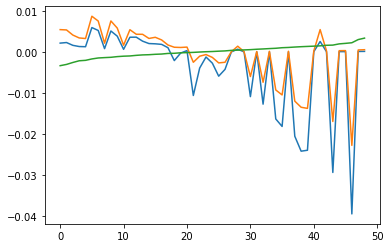

In [18]:
plt.plot(comp['mod_0_on_mod_0'])

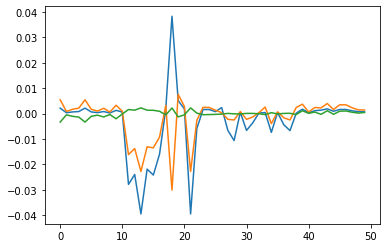

In [19]:
plt.plot(comp['mod_1_on_mod_0'])

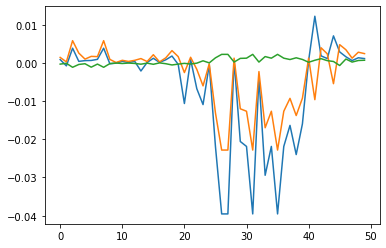

In [20]:
plt.plot(comp['mod_2_on_mod_0'])